# Relation Networks

Relation Networks (RNs) are designed for few-shot learning by explicitly learning relationships between query and support examples. They use a neural network to dynamically model similarity, enabling flexible and effective classification with minimal labeled data.

##### Step 1: Import all necessary libraries

In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Step 2: We will load RHA dataset, tranformed in .npy format using helper script.  
In helper script, we are just loading data in size format: [total_number,character,64,64].                             

In [3]:

# Function to create dataset from folders
def create_npy_from_folders(data_dir, img_size=(224, 224)):
    all_classes = sorted(os.listdir(data_dir))
    all_images = []
    min_samples = float('inf')

    for class_folder in all_classes:
        class_path = os.path.join(data_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        class_images = []
        for img_file in sorted(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_file)
            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img = Image.open(img_path).convert('L')
                    img = img.resize(img_size)
                    class_images.append(np.array(img))
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue
        min_samples = min(min_samples, len(class_images))
        all_images.append(class_images)

    truncated_images = [class_images[:min_samples] for class_images in all_images]
    dataset = np.array(truncated_images)
    np.save('data.npy', dataset)
    return dataset

# Load the dataset
data_dir = '/content/drive/MyDrive/_projects/GEI_Project/Dataset_fewshot'
dataset = create_npy_from_folders(data_dir, img_size=(224, 224))

print(f"Dataset shape: {dataset.shape}")

# Split each class separately
x_train, x_val, x_test = [], [], []
y_train, y_val, y_test = [], [], []

for class_idx in range(dataset.shape[0]):
    class_samples = dataset[class_idx]
    train, temp = train_test_split(class_samples, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    x_train.append(train)
    x_val.append(val)
    x_test.append(test)

    y_train.extend([class_idx] * len(train))
    y_val.extend([class_idx] * len(val))
    y_test.extend([class_idx] * len(test))

# Convert lists to numpy arrays
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

Dataset shape: (3, 98, 224, 224)
x_train shape: (3, 68, 224, 224), y_train shape: (204,)
x_val shape: (3, 15, 224, 224), y_val shape: (45,)
x_test shape: (3, 15, 224, 224), y_test shape: (45,)


Let's Visualize example of each class.

class 0


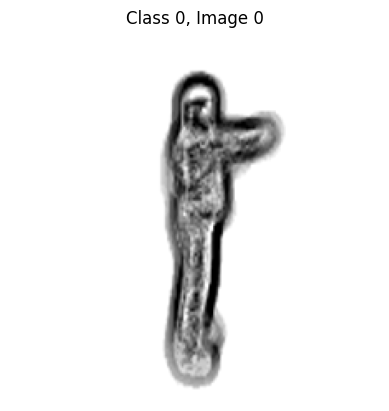

class 1


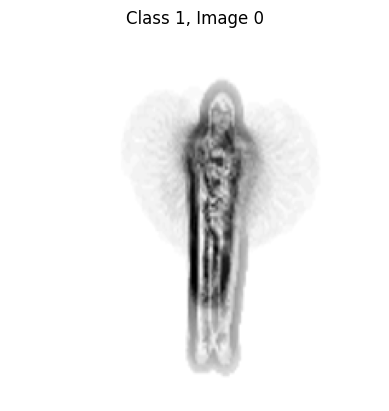

class 2


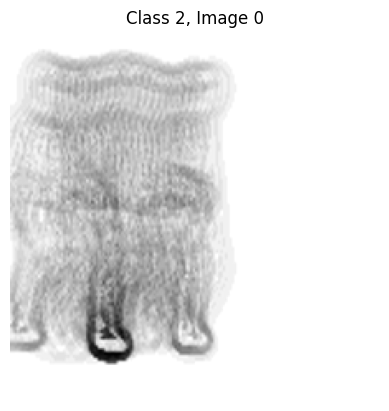

In [4]:
for class_idx in range(x_train.shape[0]):  # Loop over classes (3 classes in your case)
    print("class " + str(class_idx))
    # Extract the first image from the current class
    first_image = x_train[class_idx, 0, :, :]  # (height, width)

    # Plot the first image of each class
    plt.figure()
    plt.imshow(first_image, cmap='gray')  # Display as grayscale
    plt.title(f"Class {class_idx}, Image 0")  # Add a title with class index and image number
    plt.axis('off')  # Hide axis for better visualization
    plt.show()

###### Step 3: Training Data Processing
To Load dataset, and prepare it for Relation Networks Architecture, we need to create:
1. Label Set: Variable choose_label
2. Support Set: support_set_x, support_set_y
3. Batch from Suppport Set Examples

Let's first create a batch which can give a support set, and target set.

##### Step 3: Create a Relation Network

In [5]:

# Define the CNNEncoder class
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# Define the RelationNetwork class
class RelationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(input_size, hidden_size, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(hidden_size),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(hidden_size),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.fc1 = nn.Linear(hidden_size * 5 * 5, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the models and move them to the appropriate device
feature_encoder = CNNEncoder().to(device)
relation_network = RelationNetwork(128, 64).to(device)

# Define the optimizers
feature_encoder_optim = optim.Adam(feature_encoder.parameters(), lr=0.001)
relation_network_optim = optim.Adam(relation_network.parameters(), lr=0.001)

Using device: cpu


##### Step 3: Training the Relation Network

In [6]:
def train_relation_network(epoch, feature_encoder, relation_network, data_loader, feature_encoder_optim, relation_network_optim):
    feature_encoder.train()
    relation_network.train()

    for i, (x_support, y_support, x_query, y_query) in enumerate(data_loader):
        x_support, y_support, x_query, y_query = x_support.cuda(), y_support.cuda(), x_query.cuda(), y_query.cuda()

        support_features = feature_encoder(x_support)
        query_features = feature_encoder(x_query)

        support_features_ext = support_features.unsqueeze(0).repeat(75, 1, 1, 1, 1)
        query_features_ext = query_features.unsqueeze(0).repeat(5, 1, 1, 1, 1)

        query_features_ext = torch.transpose(query_features_ext, 0, 1)

        relation_pairs = torch.cat((support_features_ext, query_features_ext), 2).view(-1, 128, 5, 5)

        relations = relation_network(relation_pairs).view(-1, 5)

        mse = nn.MSELoss().cuda()
        one_hot_labels = torch.zeros(75, 5).scatter_(1, y_query.view(-1, 1), 1).cuda()
        loss = mse(relations, one_hot_labels)

        feature_encoder_optim.zero_grad()
        relation_network_optim.zero_grad()

        loss.backward()

        feature_encoder_optim.step()
        relation_network_optim.step()

        if i % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

#### Step 4: Testing the Model

In [7]:
def test_relation_network(feature_encoder, relation_network, data_loader):
    feature_encoder.eval()
    relation_network.eval()

    total_rewards = 0
    for i, (x_support, y_support, x_query, y_query) in enumerate(data_loader):
        x_support, y_support, x_query, y_query = x_support.cuda(), y_support.cuda(), x_query.cuda(), y_query.cuda()

        support_features = feature_encoder(x_support)
        query_features = feature_encoder(x_query)

        support_features_ext = support_features.unsqueeze(0).repeat(75, 1, 1, 1, 1)
        query_features_ext = query_features.unsqueeze(0).repeat(5, 1, 1, 1, 1)

        query_features_ext = torch.transpose(query_features_ext, 0, 1)

        relation_pairs = torch.cat((support_features_ext, query_features_ext), 2).view(-1, 128, 5, 5)

        relations = relation_network(relation_pairs).view(-1, 5)

        _, predict_labels = torch.max(relations.data, 1)

        rewards = [1 if predict_labels[j] == y_query[j] else 0 for j in range(75)]
        total_rewards += np.sum(rewards)

    accuracy = total_rewards / 75.0 / len(data_loader)
    print(f"Test Accuracy: {accuracy * 100}%")

##### Let's Run Experiments !!!!!

In [14]:
# Initialize lists to store loss and accuracy for each phase
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

# Define the number of epochs
total_epochs = 5

# Optimizers
feature_encoder_optim = optim.Adam(feature_encoder.parameters(), lr=0.001)
relation_network_optim = optim.Adam(relation_network.parameters(), lr=0.001)

# Define loss function
mse_loss = nn.MSELoss().to(device)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create Dataset instances
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)

# Create DataLoader instances with the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: few_shot_collate_fn(batch, num_support=5, num_query=15))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: few_shot_collate_fn(batch, num_support=5, num_query=15))


In [17]:
# Function to run the training or validation step
def run_epoch(data_loader, phase='train'):
    if phase == 'train':
        feature_encoder.train()
        relation_network.train()
    else:
        feature_encoder.eval()
        relation_network.eval()

    total_loss = 0.0
    total_accuracy = 0.0
    count = 0

    for i, (x_support, y_support, x_query, y_query) in enumerate(data_loader):
        x_support, y_support, x_query, y_query = x_support.to(device), y_support.to(device), x_query.to(device), y_query.to(device)

        # Squeeze the extra dimension
        x_support = x_support.squeeze(1)
        x_query = x_query.squeeze(1)

        if phase == 'train':
            feature_encoder_optim.zero_grad()
            relation_network_optim.zero_grad()

        support_features = feature_encoder(x_support)
        query_features = feature_encoder(x_query)

        support_features_ext = support_features.unsqueeze(0).repeat(x_query.size(0), 1, 1, 1, 1)
        query_features_ext = query_features.unsqueeze(0).repeat(x_support.size(0), 1, 1, 1, 1)
        query_features_ext = torch.transpose(query_features_ext, 0, 1)

        relation_pairs = torch.cat((support_features_ext, query_features_ext), 2).view(-1, 128, 5, 5)
        relations = relation_network(relation_pairs).view(-1, x_support.size(0))

        one_hot_labels = torch.zeros(x_query.size(0), x_support.size(0)).scatter_(1, y_query.view(-1, 1), 1).to(device)
        loss = mse_loss(relations, one_hot_labels)

        if phase == 'train':
            loss.backward()
            feature_encoder_optim.step()
            relation_network_optim.step()

        _, predict_labels = torch.max(relations.data, 1)
        rewards = [1 if predict_labels[j] == y_query[j] else 0 for j in range(x_query.size(0))]
        accuracy = np.sum(rewards) / x_query.size(0)

        total_loss += loss.item()
        total_accuracy += accuracy
        count += 1

    avg_loss = total_loss / count
    avg_accuracy = total_accuracy / count

    return avg_loss, avg_accuracy

In [18]:


# Custom collate function to create support and query sets
def few_shot_collate_fn(batch, num_support=5, num_query=15):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)

    unique_labels = labels.unique()
    x_support, y_support, x_query, y_query = [], [], [], []

    for label in unique_labels:
        indices = (labels == label).nonzero().squeeze()
        selected_indices = indices[torch.randperm(len(indices))]

        support_indices = selected_indices[:num_support]
        query_indices = selected_indices[num_support:num_support + num_query]

        x_support.append(images[support_indices])
        y_support.append(labels[support_indices])
        x_query.append(images[query_indices])
        y_query.append(labels[query_indices])

    return (torch.cat(x_support), torch.cat(y_support), torch.cat(x_query), torch.cat(y_query))

# Function to run the training or validation step
def run_epoch(data_loader, phase='train'):
    if phase == 'train':
        feature_encoder.train()
        relation_network.train()
    else:
        feature_encoder.eval()
        relation_network.eval()

    total_loss = 0.0
    total_accuracy = 0.0
    count = 0

    for i, (x_support, y_support, x_query, y_query) in enumerate(data_loader):
        x_support, y_support, x_query, y_query = x_support.to(device), y_support.to(device), x_query.to(device), y_query.to(device)

        # Ensure correct shape for input
        x_support = x_support.view(-1, 1, x_support.size(-2), x_support.size(-1))
        x_query = x_query.view(-1, 1, x_query.size(-2), x_query.size(-1))

        if phase == 'train':
            feature_encoder_optim.zero_grad()
            relation_network_optim.zero_grad()

        support_features = feature_encoder(x_support)
        query_features = feature_encoder(x_query)

        support_features_ext = support_features.unsqueeze(0).repeat(x_query.size(0), 1, 1, 1, 1)
        query_features_ext = query_features.unsqueeze(0).repeat(x_support.size(0), 1, 1, 1, 1)
        query_features_ext = torch.transpose(query_features_ext, 0, 1)

        relation_pairs = torch.cat((support_features_ext, query_features_ext), 2).view(-1, 128, 5, 5)
        relations = relation_network(relation_pairs).view(-1, x_support.size(0))

        one_hot_labels = torch.zeros(x_query.size(0), x_support.size(0)).scatter_(1, y_query.view(-1, 1), 1).to(device)
        loss = mse_loss(relations, one_hot_labels)

        if phase == 'train':
            loss.backward()
            feature_encoder_optim.step()
            relation_network_optim.step()

        _, predict_labels = torch.max(relations.data, 1)
        rewards = [1 if predict_labels[j] == y_query[j] else 0 for j in range(x_query.size(0))]
        accuracy = np.sum(rewards) / x_query.size(0)

        total_loss += loss.item()
        total_accuracy += accuracy
        count += 1

    avg_loss = total_loss / count
    avg_accuracy = total_accuracy / count

    return avg_loss, avg_accuracy

# Loop over epochs
for epoch in range(total_epochs):
    # Training Step
    train_c_loss, train_acc = run_epoch(train_loader, phase='train')
    train_loss.append(train_c_loss)
    train_accuracy.append(train_acc)

    # Validation Step
    val_c_loss, val_acc = run_epoch(val_loader, phase='val')
    val_loss.append(val_c_loss)
    val_accuracy.append(val_acc)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{total_epochs}: "
          f"train_loss: {train_c_loss:.4f}, train_accuracy: {train_acc:.4f}, "
          f"val_loss: {val_c_loss:.4f}, val_accuracy: {val_acc:.4f}")

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

Now Let's obtain our test accuracy by running the following code block:

In [ ]:
# Testing Step
total_test_c_loss, total_test_accuracy = run_epoch(test_loader, phase='test')
print("test_accuracy:{}%".format(total_test_accuracy * 100))

#### Step 10: Let's visualize our results

In [ ]:
# Function to plot loss and accuracy
def plot_metrics(train, val, name1="train", name2="val", title=""):
    plt.figure()
    plt.title(title)
    plt.plot(train, label=name1)
    plt.plot(val, label=name2)
    plt.legend()
    plt.show()

# Plot loss graph
plot_metrics(train_loss, val_loss, "train_loss", "val_loss", "Loss Graph")

# Plot accuracy graph
plot_metrics(train_accuracy, val_accuracy, "train_accuracy", "val_accuracy", "Accuracy Graph")

In [ ]:
# Plot accuracy graph
plot_metrics(train_accuracy, val_accuracy, "train_accuracy", "val_accuracy", "Accuracy Graph")